# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
 -1
  1
  1
 -1
 -1
  1
  1
  1
  ⋮
 -1
  1
  1
 -1
 -1
 -1
  1
  1
  1

### We create a function to visualize the data

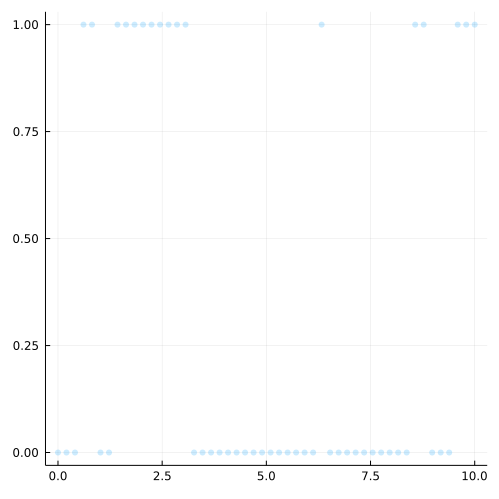

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.958867 seconds (1.82 M allocations: 103.804 MiB, 99.42% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.9346227607820056, 0.857170958304825, 0.7606555815689587, 0.6650829362457956, 0.611649972384487, 0.6474599986556474, 0.7759213318643798, 0.9533062410010316, 1.1307368251380905, 1.2701187991298284  …  1.1888843564033702, 1.036086228042082, 0.8819778462135193, 0.745635260304331, 0.6493219445865992, 0.6121818406745687, 0.6358819364073461, 0.7007414980266329, 0.7813292784229406, 0.8588078622124048], θ = [0.23326224304878165, 0.2357397270858424, 0.2386047708258942, 0.24117484424218077, 0.24248687623182003, 0.24161778557245564, 0.23816899339340825, 0.23264255904074477, 0.2263788056060723, 0.22105261639949617  …  0.22419461695136916, 0.22980146736277615, 0.23496271770258562, 0.23902692224344174, 0.24157145693346924, 0.24247427606535094, 0.24190335594025464, 0.24024858209894395, 0.238013009715

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:19
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:42
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:48
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:20
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:04
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:46
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:40
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:26
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.4297399492966861, -0.6849793703145508, -0.9078779205451897, -1.0008087462671789, -0.9863573479387573, -0.8421508795263948, -0.5856194015199415, -0.29559832667074093, 0.03233412348012299, 0.3249186020143118  …  -1.5108365165381437, -1.4537092273704817, -1.288769734902338, -1.023004817755727, -0.7030333403355491, -0.41368070137654933, -0.149435947746963, -0.0882040212144028, -0.09843829584506725, -0.18323850279324172]]
 [[-0.13111060625282867, -0.12858524953061728, -0.058101915476149735, 0.08380897867852372, 0.26944315123607293, 0.44573964073756156, 0.5740916107437171, 0.6380642471818236, 0.6241622141902585, 0.5453653679487198  …  -0.6165145997938337, -0.1559473174771046, 0.23764614149497498, 0.5355258795718114, 0.6881164623401095, 0.7211780637307172, 0.6001577256774808, 0.38578846285672663, 0.1709780790611466, -0.001666729818846302]]
 [[-0.8229196887496855, -0.6053370628755078, -0.4073859348245502, -0.15774821392023905, 0.0165474503757

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

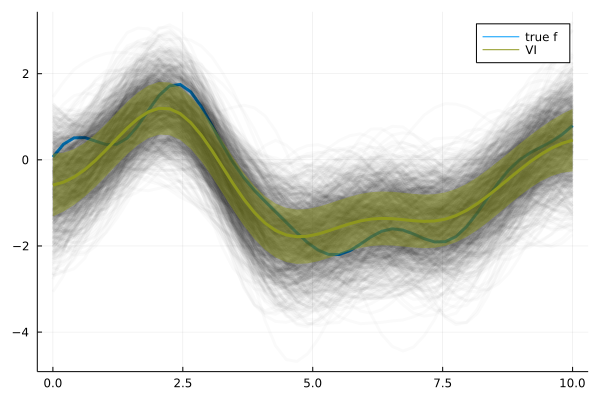

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

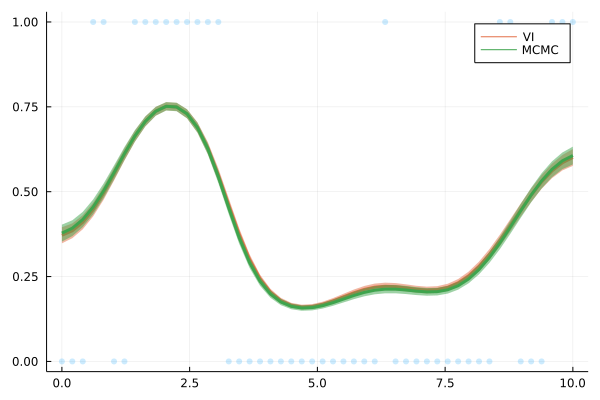

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*